In [5]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import sys

yolo_dir = Path.home()/'yolov5'
if yolo_dir.is_dir():
    sys.path.append(str(yolo_dir))

from utils.tools.general import *
from utils.tools.type_checker import is_2d_img, is_color_img, is_grey_img, is_bool_mask
from IPython.display import display
from tqdm.notebook import tqdm


import imageio
import boxx
import utils.tools.image as iu
from utils.tools.image import img_height_width, mask_area
import imgaug.augmenters as iaa
from utils.paster.paster import PasteMaskedImage

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:

def format_disk(device_name):
    !sudo mkfs.ext4 -m 0 -E lazy_itable_init=0,lazy_journal_init=0,discard /dev/{device_name}

def mount_disk(device_name, mount_dir):
    !sudo mkdir -p /mnt/disks/{mount_dir}
    !sudo mount -o discard,defaults /dev/{device_name} /mnt/disks/{mount_dir}
    !sudo chmod a+w /mnt/disks/{mount_dir}

# mount_disk('sdb', 'lightbox_hand_eccsd-copy')
mount_disk('sdd', 'lightbox_hand_eccsd-copy')
!sudo lsblk 

mount: /mnt/disks/lightbox_hand_eccsd-copy: /dev/sdd already mounted on /mnt/disks/lightbox_hand_eccsd-copy.
NAME    MAJ:MIN RM   SIZE RO TYPE MOUNTPOINT
loop0     7:0    0  55.5M  1 loop /snap/core18/2246
loop1     7:1    0  55.5M  1 loop /snap/core18/2253
loop2     7:2    0  61.9M  1 loop /snap/core20/1169
loop3     7:3    0  61.9M  1 loop /snap/core20/1242
loop4     7:4    0 251.7M  1 loop /snap/google-cloud-sdk/207
loop5     7:5    0 251.7M  1 loop /snap/google-cloud-sdk/206
loop6     7:6    0  32.5M  1 loop /snap/snapd/13640
loop7     7:7    0  67.2M  1 loop /snap/lxd/21803
loop8     7:8    0  67.2M  1 loop /snap/lxd/21835
loop9     7:9    0  42.2M  1 loop /snap/snapd/14066
sda       8:0    0    20G  0 disk 
├─sda1    8:1    0  19.9G  0 part /
├─sda14   8:14   0     4M  0 part 
└─sda15   8:15   0   106M  0 part /boot/efi
sdb       8:16   0    10G  0 disk 
sdc       8:32   0    10G  0 disk 
sdd       8:48   0    10G  0 disk /mnt/disks/lightbox_hand_eccsd-copy
sde       8:64   0    

In [7]:
back_img_dpath = yolo_dir/'datasets/coco128/images/train2017'
bimg_paths = pd.Series(back_img_dpath.ls('*.jpg'))

front_img_dpath = Path('/mnt/disks/lightbox_hand_eccsd-copy')

# create coco and load image

loading annotations into memory...
Done (t=1.25s)
creating index...
index created!
 angles list: ['tb45' 't45' 't90' 'hb45' 'tb90' 'h45']
loading annotations into memory...
Done (t=0.34s)
creating index...
index created!
loading annotations into memory...
Done (t=0.09s)
creating index...
index created!


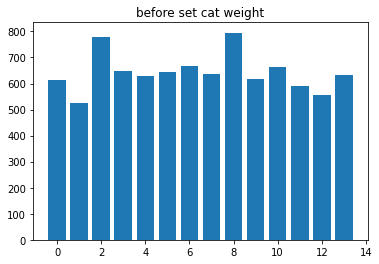

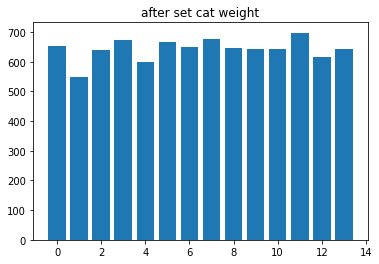

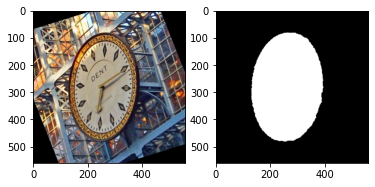

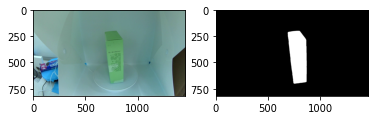

[None, None]

In [8]:
from utils.paster.create_datasets import LoadProductWithNoise
mixed_coco = LoadProductWithNoise()
[mask_img.show_both() for mask_img in mixed_coco.next_batch_with_multiple_dataset(bs=2)]

In [9]:
def get_back_img(idx=0):
    return imageio.imread(bimg_paths[idx])

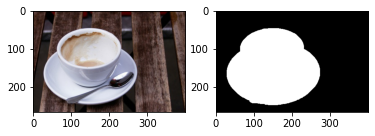

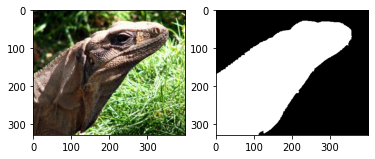

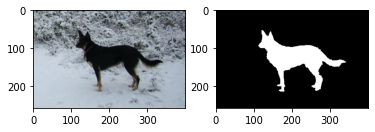

In [10]:
masked_imgs = mixed_coco.eccsd_coco.next_batch(3, create_obj=True)
for m in masked_imgs:
    m.show_both()

test_aug_seq = iaa.Sequential([
    iaa.Rotate((-180, 180))
])

mixed_coco.next_batch_and_transform(mixed_coco.lb_coco, test_aug_seq)

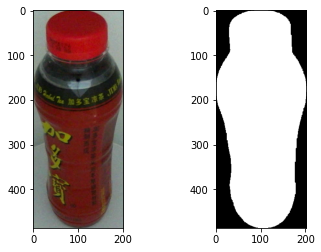

(dtype('uint8'), dtype('bool'))

In [11]:
mask_img = mixed_coco.next_batch_with_multiple_dataset(bs=1)[0]
boxx.show(mask_img.cropped_img, mask_img.cropped_mask)
mask_img.cropped_img.dtype, mask_img.cropped_mask.dtype

# draw point for pasted mask

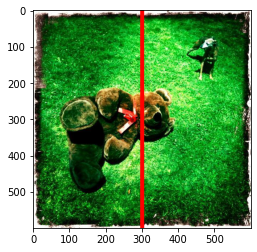

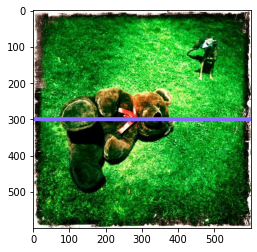

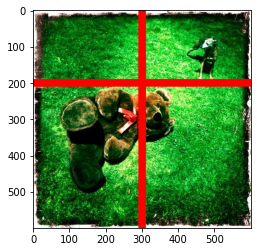

In [12]:
import cv2

def draw_line(image, start_point, end_point, color='blue', thickness=10, copy=False):
    colors = {
        'blue': (132,112,255),
        'red': (255,0, 0),
    }

    if copy:
        image = image.copy()
    cv2.line(image, tuple(start_point), tuple(end_point), colors[color], thickness)
    return image
    

def vertical_line(image, coord_x, **kwargs):
    h, w = img_height_width(image)
    draw_line(image, (coord_x, 0), (coord_x, w), **kwargs)

def horizontal_line(image, coord_y, **kwargs):
    h, w = img_height_width(image)
    draw_line(image, (0, coord_y), (h, coord_y), **kwargs)

def draw_crosshair(image, x, y, **kwargs):
    vertical_line(image, x, **kwargs, copy=False)
    horizontal_line(image, y, **kwargs, copy=False)


test_back_img = get_back_img()
vertical_line(test_back_img, 300, color='red')
boxx.show(test_back_img)

test_back_img = get_back_img()
horizontal_line(test_back_img, 300)
boxx.show(test_back_img)

test_back_img = get_back_img()
draw_crosshair(test_back_img, 300, 200, color='red', thickness=20)
boxx.show(test_back_img)


draw line after paste to check coordinate

In [13]:
class RandomCoordOnImage:
    def __init__(self, image:np.ndarray):
        h,w = img_height_width(image)
        x = np.random.randint(0, w)
        y = np.random.randint(0, h)
        self.point = (x,y)

point:  (525, 141)
bbox after paste(xyxy):  [459, 0, 592, 344]


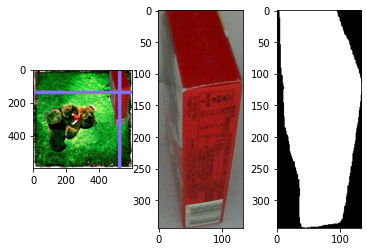

--------------------------------------------------
point:  (400, 172)
bbox after paste(xyxy):  [169, 0, 600, 373]


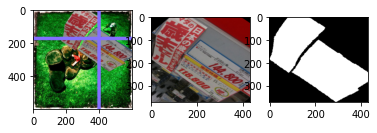

--------------------------------------------------
point:  (171, 250)
bbox after paste(xyxy):  [93, 131, 249, 369]


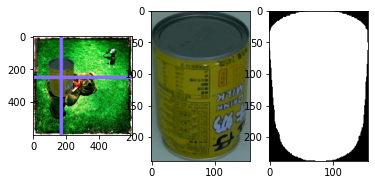

--------------------------------------------------
point:  (283, 145)
bbox after paste(xyxy):  [41, 0, 526, 388]


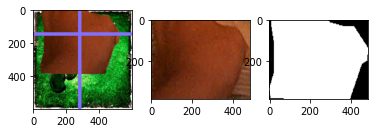

--------------------------------------------------
point:  (6, 323)
bbox after paste(xyxy):  [0, 146, 115, 501]


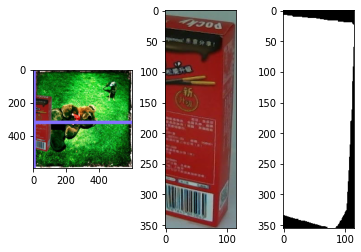

--------------------------------------------------


In [14]:
for i in range(5):
    test_back_img = get_back_img()
    masked_img = mixed_coco.next_batch_with_multiple_dataset(1)[0]
    cropped_img, cropped_mask = masked_img.cropped_img, masked_img.cropped_mask

    # point = (300, 100)
    point = RandomCoordOnImage(test_back_img).point
    '''jump'''
    paster = PasteMaskedImage(test_back_img)
    test_back_img, bbox, visible_front, visible_mask = paster.paste_object(cropped_img, cropped_mask, point)
    # image_dst, coords, visible_front, visible_mask = paste_object(test_back_img, cropped_img, *point, image_src_mask=cropped_mask)



    print(f"point:  {point}")
    print(f"bbox after paste(xyxy):  {bbox}")
    draw_crosshair(test_back_img, *point, thickness=20)
    boxx.show(test_back_img, visible_front, visible_mask)#, cropped_img, cropped_mask)
    dash()


# setup transformer params for augmentation

resize in uniform distribution,
                range([0.3, 0.7]) will be used as distribution's min max
plot resize distribution:


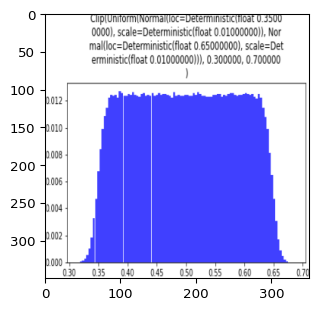

In [15]:
import utils.tools.file as fu
from utils.tools.image import stochastic_params, show_dist

hyp_dict = fu.load_yaml(yolo_dir/'utils'/'paste_hyp.yaml')

def set_hyp_dict( hyp_dict):
    ## assign tuple for range between (min, max) in imgaug library
    keys_with_range = ["rotate", "batch_resize"]
    hyp_dict_old = hyp_dict.copy()
    if "batch_resize_distribution" in hyp_dict and hyp_dict[
        "batch_resize_distribution"
    ] in ["normal", "uniform"]:

        hyp_dict["batch_resize"] = stochastic_params(
            *hyp_dict_old["batch_resize"], dist=hyp_dict_old["batch_resize_distribution"]
        )
        print(
            f"""resize in {hyp_dict_old["batch_resize_distribution"]} distribution,
                range({hyp_dict_old['batch_resize']}) will be used as distribution's min max"""
        )
        print("plot resize distribution:")
        show_dist([hyp_dict["batch_resize"]])

        hyp_dict["rotate"] = tuple(hyp_dict_old["rotate"])
    else:
        for k in keys_with_range:
            hyp_dict[k] = tuple(hyp_dict_old[k])

    for c in "hsv":
        hyp_dict["hsv_" + c][1] = tuple(hyp_dict_old["hsv_" + c][1])

    
    hyp_dict["m_blur_chance"] = hyp_dict_old["motion_blur"][0]
    hyp_dict["m_blur_kernel"] = tuple(hyp_dict_old["motion_blur"][1])
    hyp_dict["m_blur_angle"] = tuple(hyp_dict_old["motion_blur"][2])

    hyp_dict["dropout"] = {}
    hyp_dict["dropout"]["chance"] = hyp_dict_old["dropout"][0]
    hyp_dict["dropout"]["p"] = tuple(hyp_dict_old["dropout"][1])
    hyp_dict["dropout"]["per_channel"] = hyp_dict_old["dropout"][2]
    return hyp_dict

hyp_dict = set_hyp_dict( hyp_dict)

In [16]:
from utils.paste_product import aug_front_img, batch_resize, depth_level_resize
from utils.gen_image import aug_during_paste


def color_chnl_adjust(chnl, values):
    return iaa.WithChannels(
        chnl,
        iaa.Add(values),
    )


adjust_hsv = iaa.WithColorspace(
            to_colorspace="HSV",
            from_colorspace="RGB",
            children=iaa.Sequential(
                [
                    iaa.Sometimes(
                        hyp_dict["hsv_h"][0],  # chance
                        color_chnl_adjust(0, hyp_dict["hsv_h"][1]),  # (min, max)
                    ),
                    iaa.Sometimes(
                        hyp_dict["hsv_s"][0],
                        color_chnl_adjust(1, hyp_dict["hsv_s"][1]),
                    ),
                    iaa.Sometimes(
                        hyp_dict["hsv_v"][0],
                        color_chnl_adjust(2, hyp_dict["hsv_v"][1]),
                    ),
                ]
            ),
        )

aug_funcs_dict = {
            0: None,
            1: None,
            2: None,
            3: None,
            4: None,
            5: None,
            6: None,
            7: None,
            8: None,
            9: None,
            10: None,
            11: None,
            12: None,
            13: None,
            14: None,
        }

motion_blur = iaa.MotionBlur(
            k= hyp_dict["m_blur_kernel"], angle= hyp_dict["m_blur_angle"]
)

# paste with DebugPaster

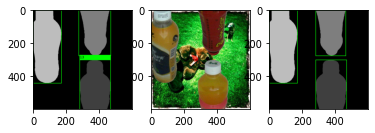

,0,1,2
class before replace,13,12,6
cls_id,13,12,6
is_noise_class,False,False,False
len(bbox),4,4,4
labels before clean,"[13, 284, 303, 469, 600]","[12, 278, 0, 470, 276]","[6, 0, 0, 171, 442]"
labels after clean,"[13, 284, 303, 469, 600]","[12, 278, 0, 470, 276]","[6, 0, 0, 171, 442]"
bboxes,"[284, 303, 469, 600]","[278, 0, 470, 276]","[0, 0, 171, 442]"
visible_bboxes,"[284, 303, 469, 600]","[284, 0, 464, 276]","[0, 0, 171, 442]"
front_mask_areas,63463,63531,67002
mask_area_after_overlapped,43846,35857,62559


In [18]:
from utils.paster.paster import DebugPaster
test_back_img = get_back_img()
db_paster = DebugPaster(test_back_img, save_mask=True)
db_paster.batch_pasting_flow(n=3, coco=mixed_coco, show_pasted_mask=True, show_debug_info=True)
db_paster.show_debug_info()

In [29]:
pasters[0].get_debug_info()

,0,1,2
class before replace,5,-1,-1
cls_id,5,-1,-1
is_noise_class,False,True,True
len(bbox),4,4,4
labels before clean,"[5, 116, 118, 279, 544]","[-1, 0, 0, 0, 0]","[-1, 0, 0, 0, 0]"
labels after clean,None,None,None
bboxes,"[116, 118, 279, 544]","[0, 0, 446, 558]","[0, 181, 222, 445]"
visible_bboxes,"[189, 118, 278, 231]","[0, 0, 446, 558]","[0, 181, 222, 441]"
front_mask_areas,54547,262444,38757
mask_area_after_overlapped,6613,145429,34669


  0%|          | 0/10 [00:00<?, ?it/s]

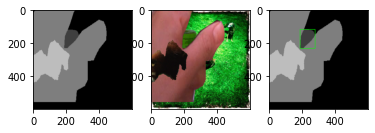

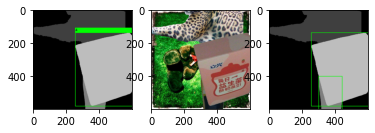

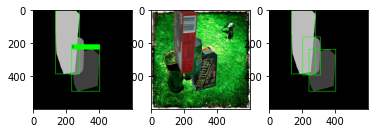

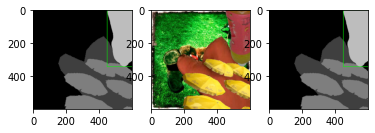

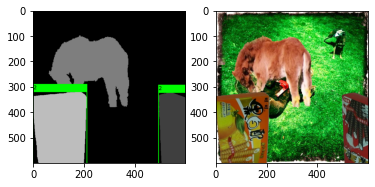

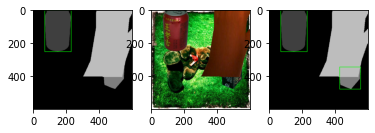

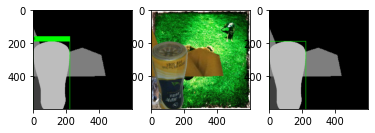

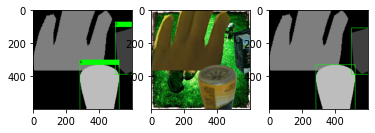

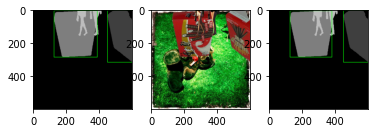

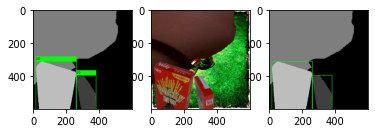

In [28]:
pasters = []
for i in tqdm(range(10)):
    test_back_img = get_back_img()
    db_paster = DebugPaster(test_back_img, save_mask=True)
    db_paster.batch_pasting_flow(n=3, coco=mixed_coco, show_pasted_mask=True, show_debug_info=True)
    pasters.append(db_paster)

In [ ]:
db_paster.show_debug_info()

,0,1,2
class before replace,1,-1,-1
cls_id,1,-1,-1
is_noise_class,False,True,True
len(bbox),4,4,4
labels before clean,"[1, 438, 124, 600, 479]","[-1, 0, 0, 0, 0]","[-1, 0, 0, 0, 0]"
labels after clean,"[1, 438, 124, 600, 479]",None,None
front_mask_areas,70189,192976,98770
mask_area_after_overlapped,39858,99361,41168
pct,0.567867,0.514888,0.416807
visible_too_lows,False,False,False


## Batch pasting to test paster
- find the visible area after pasted then create bounding box based on it
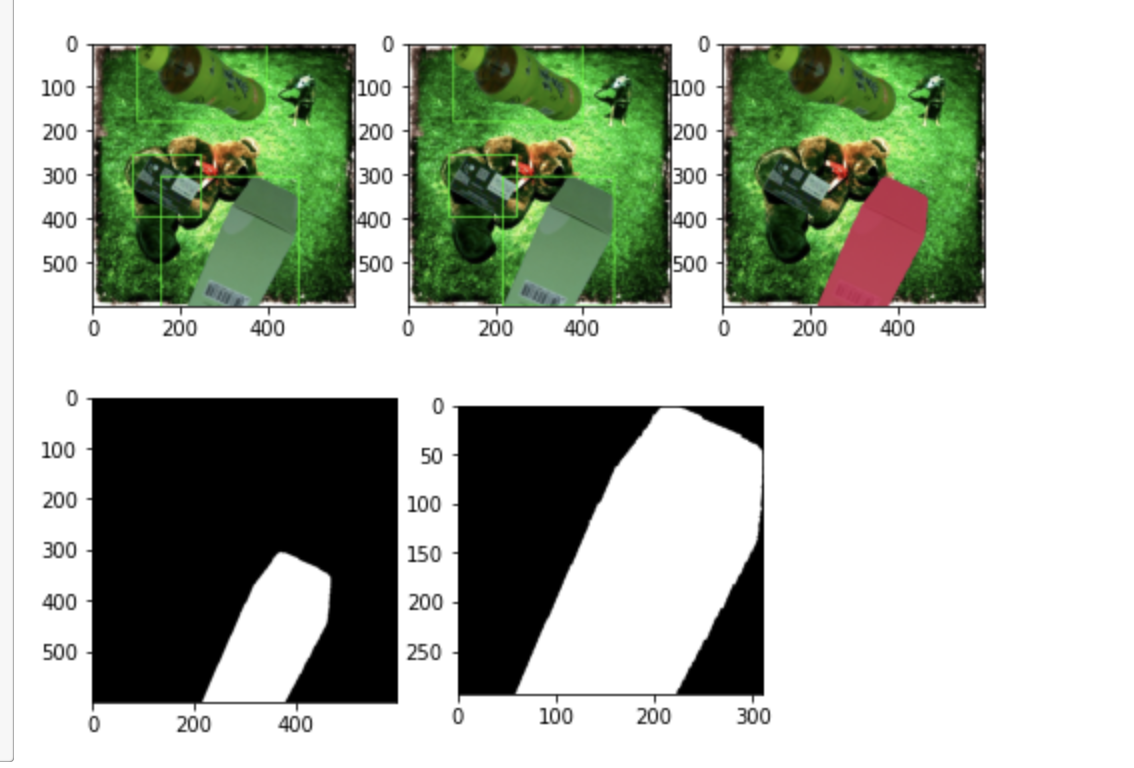

In [ ]:
def remaining_area_pct(mask_area_before_paste: int, mask_area_after_paste: int):
    return 1 - (mask_area_before_paste - mask_area_after_paste) / mask_area_before_paste

def is_noise_class(cls_id):
    return int(cls_id) < 0

In [ ]:
def stack_grey_img_to_3chnl(grey_img):
    return np.stack([grey_img for i in range(3)]).transpose(1,2,0)

def draw_sequence_mask(back_mask, labels, copy=True):
    if copy:
        back_mask = back_mask.copy()
    hsv_mask = cv2.cvtColor(stack_grey_img_to_3chnl(back_mask.astype('uint8')), cv2.COLOR_RGB2HSV)
    value_count = len(np.unique(hsv_mask))
    brightness_ratio = 255 // value_count
    hsv_mask[:,:, 1] = hsv_mask[:,:, 1] * brightness_ratio
    hsv_mask[:,:, 2] = hsv_mask[:,:, 2] * brightness_ratio
    rgb_mask = cv2.cvtColor(hsv_mask, cv2.COLOR_HSV2RGB)
    # print(f"img_info(draw_sequence_mask):  {iu.img_info(rgb_mask)}")
    return iu.draw_bb(rgb_mask, labels, has_cls_id=True)

In [ ]:
def batch_pasting_with_class(back_img, augmented_small_imgs, show_pasted_mask=False, debug_info=False, show_area=False):
    
    '''jump'''
    paster = PasteMaskedImage(back_img, save_mask=True)

    bbox_to_remove = []
    labels = []
    visible_masks = []
    visible_fronts = []
    front_mask_areas = []
    for i, (front_img, segmap, cls_id) in enumerate(augmented_small_imgs):
        

        bool_mask = segmap.get_arr() > 0
        if not (is_color_img(front_img) and is_bool_mask(bool_mask)):
            continue
        
        front_mask_areas.append(mask_area(bool_mask))
        point = RandomCoordOnImage(back_img).point
        back_img, bbox, visible_front, visible_mask = paster.paste_object(front_img, bool_mask, point)
        '''jump n'''
        if is_noise_class(cls_id) or not len(bbox):
            bbox_to_remove.append(True)
            labels.append([-1, 0,0,0,0]) #cls_id, xyxy
        else:
            bbox_to_remove.append(False)
            labels.append([cls_id, *bbox])
        
        visible_masks.append(visible_mask.astype('bool'))
        visible_fronts.append(visible_front)


    
    if show_area:
        print(f"front_mask area before paste: {front_mask_areas}")
        print(f"original pasted visible mask_area: {[mask_area(m) for m in visible_masks]}")
        print(f"real visible_mask_area after overlapped by paste: {paster.visible_mask_areas}")


    if paster._save_mask:
        '''jump'''
        #bbox not tally with the previous bbox?
        final_visible_front_masks = paster.find_visible_mask_on_back_img()
        bboxes = [iu.bbox_from_mask(m.astype('bool')) for m in final_visible_front_masks]
        paster.cal_visible_mask_areas()
        visible_too_lows = []
        for i, mask_area_after_overlapped in enumerate(paster.visible_mask_areas):
            area_pct_after_paste = remaining_area_pct(front_mask_areas[i], mask_area_after_overlapped) 
            visible_too_lows.append(area_pct_after_paste < hyp_dict['overlap_thereshold'])
            
            if debug_info:
                print(f"cls_id:  {labels[i][0]}")
                print(f'pct {i}: {remaining_area_pct(front_mask_areas[i], mask_area_after_overlapped)}')
                print(f'area {i}: {[front_mask_areas[i], mask_area_after_overlapped]}')
                print(f"visible_too_lows[i]:  {visible_too_lows[i]}")
                dash()
                


        labels = np.array(labels)
        bbox_to_remove = np.array(bbox_to_remove)
        visible_too_lows = np.array(visible_too_lows)

        if debug_info:
            print('remove bbox: ')
            print(bbox_to_remove)
            print(visible_too_lows)
            dash(20)
            print(bbox_to_remove | visible_too_lows)
            dash()

        bbox_to_remove = (bbox_to_remove | visible_too_lows)

        
        if debug_info:
            print(f"labels before clean:")
            print(labels)
        labels = labels[~bbox_to_remove]
        if debug_info:
            print(f"labels after clean:")
            print(labels)

        if show_pasted_mask:
            boxx.show(draw_sequence_mask(paster.back_mask, labels), paster.back_img)

    return back_img, labels, visible_masks, visible_fronts, paster

cls_id:  4
pct 0: 0.8042179180133466
area 0: [86014, 69174]
visible_too_lows[i]:  False
--------------------------------------------------
cls_id:  2
pct 1: 0.608433734939759
area 1: [30046, 18281]
visible_too_lows[i]:  False
--------------------------------------------------
cls_id:  -1
pct 2: 0.6006620570173403
area 2: [64647, 38831]
visible_too_lows[i]:  False
--------------------------------------------------
front_mask area before paste: [86014, 30046, 64647]
original pasted visible mask_area: [69174, 18281, 38831]
real visible_mask_area after overlapped by paste: [69174, 18281, 38831]
remove bbox: 
[False False  True]
[False False False]
--------------------
[False False  True]
--------------------------------------------------
labels before clean:
[[  4 422 162 600 600]
 [  2 310 370 396 600]
 [ -1   0   0   0   0]]
labels after clean:
[[  4 422 162 600 600]
 [  2 310 370 396 600]]


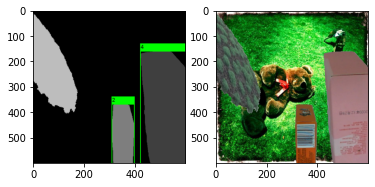

In [ ]:
def test_next_batch_then_paste(**kwargs):

    augmented_small_imgs =[]
    for i, masked_img in enumerate(mixed_coco.next_batch_with_multiple_dataset(3)):
        front_img = masked_img.cropped_img
        bool_mask = masked_img.cropped_mask
        cls_id = masked_img.cls_id
        augmented_small_imgs.append([front_img, iu.get_segmap(front_img, bool_mask), cls_id])


    hyp_dict['overlap_thereshold'] = 0.4
    test_back_img = get_back_img()
    pasted_back_img, bboxes, visible_masks, visible_fronts, test_paster = batch_pasting_with_class(test_back_img, augmented_small_imgs,
                                                                                 **kwargs)


test_next_batch_then_paste(show_pasted_mask=True, debug_info=True, show_area=True)


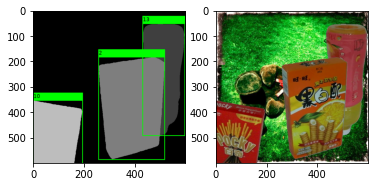

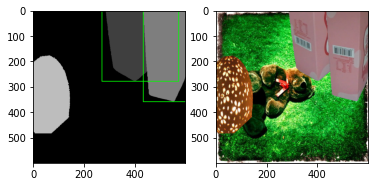

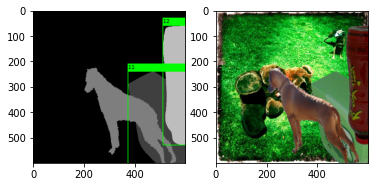

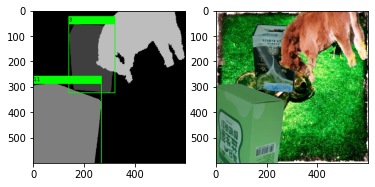

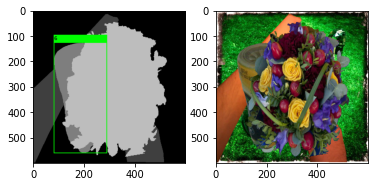

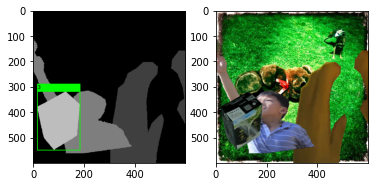

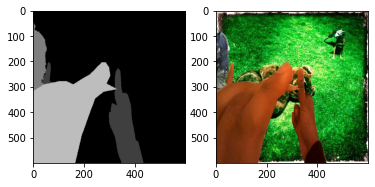

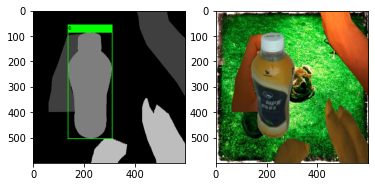

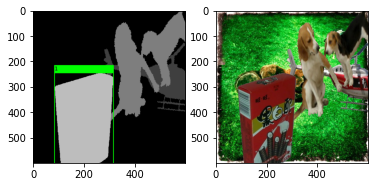

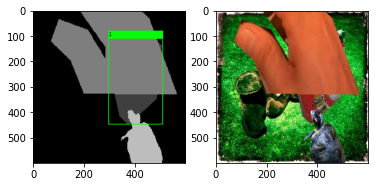

In [ ]:
for i in range(10):
    test_next_batch_then_paste(show_pasted_mask=True, debug_info=False)

- if the front img is clipped out of bbox after paste, 
    - `original pasted visible mask_area` will be less than `front_mask area before paste`
- if front img pasted is overlapped by after pasted img,
    - `real visible_mask_area after overlapped by paste` will be less than `original pasted visible mask_area`

# test

## stress test

test pasting coordinate whether got error

In [ ]:
# %%time
# '''same back img'''
# n = 100
# for i in tqdm(range(n)):
#     augmented_small_imgs = next_batch_and_transform(lb_coco)
#     pasted_back_img, bboxes, visible_masks, visible_fronts = batch_pasting(back_img.copy(), augmented_small_imgs)
#     correct_bboxes = correct_bbox_area_after_paste(pasted_back_img, bboxes, visible_masks)

In [ ]:
# %%time
# '''different back img'''

# n = 100

# for i in tqdm(range(n)):
#     try:
#         test_b_img_path = pd.Series(back_img_dpath.ls('*.jpg')).sample(1).values[0]
#         # test_b_img_path = Path('/home/cheeyung/yolov5/datasets/coco128/images/train2017/000000000086.jpg')
#         test_b_img = iu.read_color_img(test_b_img_path)


        
        
#         augmented_small_imgs = next_batch_and_transform(lb_coco)
#         pasted_back_img, bboxes, visible_masks, visible_fronts = batch_pasting(test_b_img, augmented_small_imgs)
#         correct_bboxes = correct_bbox_area_after_paste(pasted_back_img, bboxes, visible_masks)
#     except ValueError as e:
#         if 'Only color img allowed' in e.args:
#             print('Only color img allowed, image will be skip')
#             continue
#         else:
#             raise e